In [1]:
import os
from glob import glob

import cv2

from skimage import io, color
import matplotlib.pyplot as plt
from matplotlib.image import imread
import numpy as np
import xarray as xr
import rioxarray as rxr
import earthpy as et
import earthpy.spatial as es
import earthpy.plot as ep



In [2]:
landsat_path = os.getcwd()
paths = glob(os.path.join(landsat_path, "Bands", "*BAND*.TIF"))
paths.sort()


In [3]:
def open_clean_bands(band_path):     
    return rxr.open_rasterio(band_path, masked=True).squeeze()

all_bands = []
for i, aband in enumerate(paths):
    all_bands.append(open_clean_bands(aband))
    # Assign a band number to the new xarray object
    all_bands[i]["band"]=i+1


In [4]:
landsat__xr = xr.concat(all_bands,  dim="band") 

In [5]:
print(landsat__xr.shape)

(7, 7741, 7591)


In [34]:
print(landsat__xr[6].values)

[[nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 ...
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]]


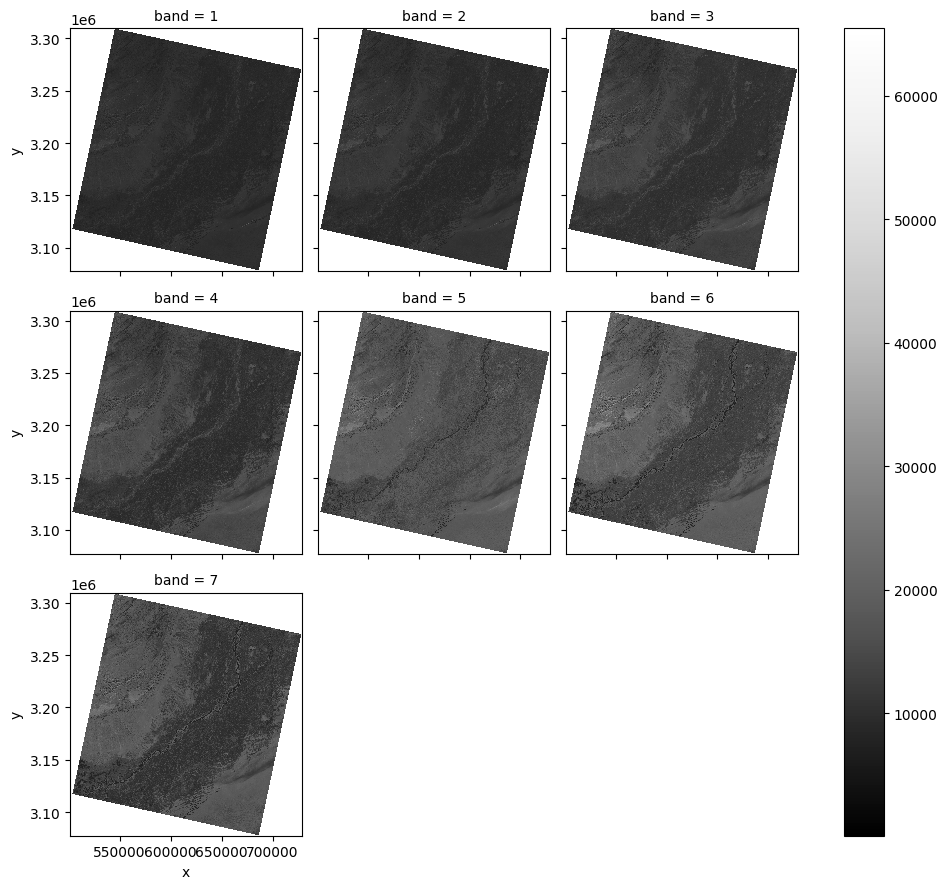

In [5]:
landsat__xr.plot.imshow(col="band", col_wrap=3,cmap="Greys_r")
plt.show()

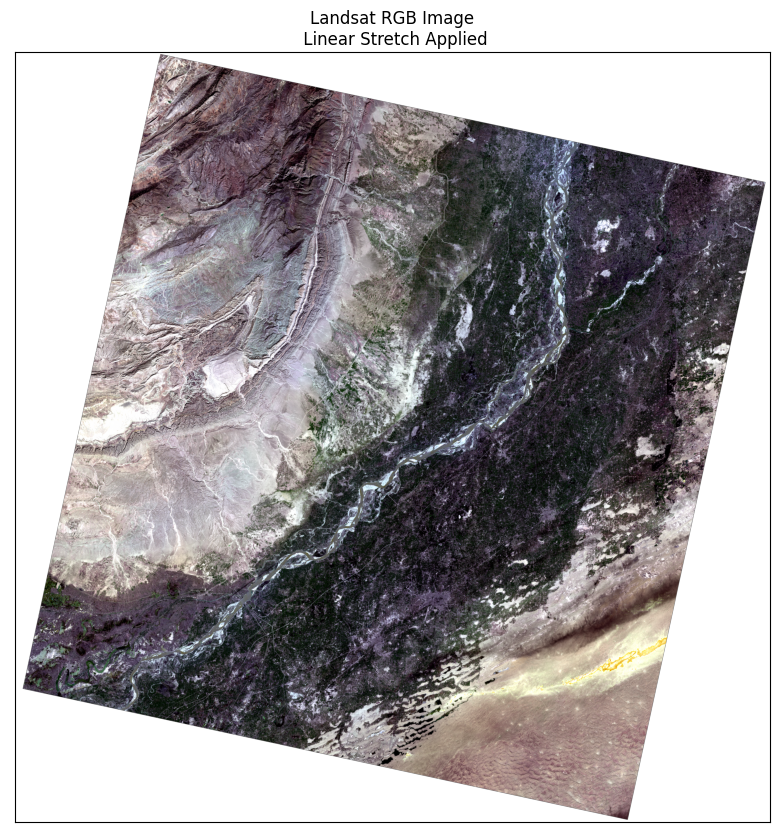

<AxesSubplot: title={'center': 'Landsat RGB Image\n Linear Stretch Applied'}>

In [5]:
ep.plot_rgb(landsat__xr.values,
            rgb=[3, 2, 1],
            title="Landsat RGB Image\n Linear Stretch Applied",
            stretch=True,
            str_clip=2)


In [6]:
img = cv2.cvtColor(cv2.imread(paths[6]) , cv2.COLOR_BGR2RGB)

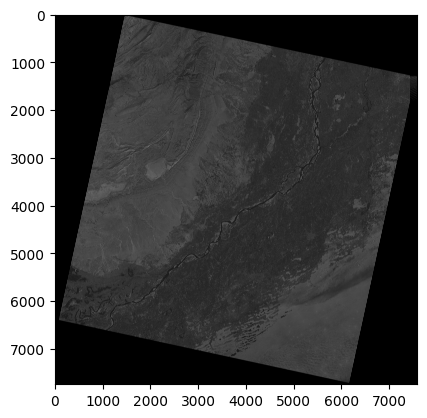

In [7]:
plt.imshow(img)

In [28]:
print(img.shape)

(7741, 7591, 3)


In [8]:
dim = (400, 400)
  
# resize image
resized = cv2.resize(img, dim, interpolation = cv2.INTER_AREA)

In [9]:
print(resized.shape)

(400, 400, 3)


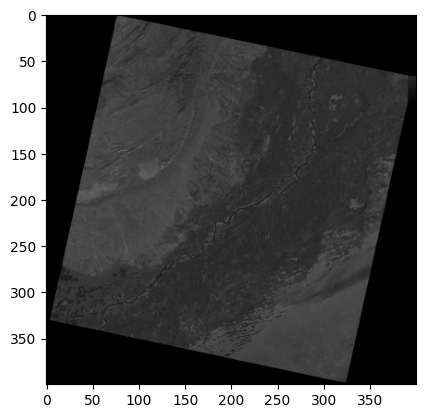

In [6]:

plt.imshow(resized)

In [10]:
lina_gray = color.rgb2gray(resized)

In [9]:
print(lina_gray.shape)

(400, 400)


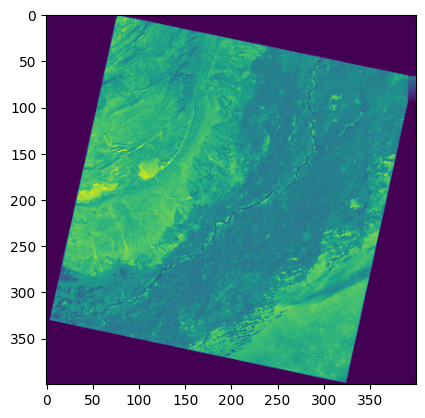

In [10]:
plt.imshow(lina_gray)

In [11]:

r , g, b = cv2.split(resized)

r,g,b = r/255 , g/255, b/255
r = np.array(r)
g = np.array(g)
b = np.array(b)


In [11]:
print(r.shape)

(400, 400)


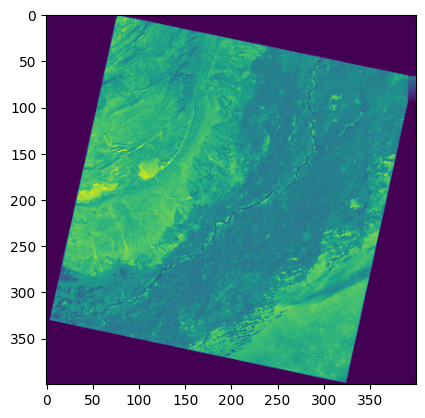

In [26]:
plt.imshow(r)

In [12]:
class convers_pca():
    def __init__(self, no_of_components):
        self.no_of_components = no_of_components
        self.eigen_values = None
        self.eigen_vectors = None
        
    def transform(self, x):
        return np.dot(x - self.mean, self.projection_matrix.T)
    
    def inverse_transform(self, x):
        return np.dot(x, self.projection_matrix) + self.mean
    
    def fit(self, x):
        self.no_of_components = x.shape[1] if self.no_of_components is None else self.no_of_components
        self.mean = np.mean(x, axis=0)
        
        cov_matrix = np.cov(x - self.mean, rowvar=False)
        
        self.eigen_values, self.eigen_vectors = np.linalg.eig(cov_matrix)
        self.eigen_vectors = self.eigen_vectors.T
        
        self.sorted_components = np.argsort(self.eigen_values)[::-1]
        
        self.projection_matrix = self.eigen_vectors[self.sorted_components[:self.no_of_components]]
        self.explained_variance = self.eigen_values[self.sorted_components]
        self.explained_variance_ratio = self.explained_variance / self.eigen_values.sum()

In [16]:
pca_components = 10

pca_r = convers_pca(no_of_components = pca_components)
pca_r.fit(r)
reduced_r = pca_r.transform(r)

pca_g = convers_pca(no_of_components = pca_components)
pca_g.fit(g)
reduced_g = pca_r.transform(g)

pca_b = convers_pca(no_of_components = pca_components)
pca_b.fit(b)
reduced_b = pca_r.transform(b)

In [17]:
combined = np.array([reduced_r,reduced_g,reduced_b])


In [18]:
print(combined.shape)

(3, 400, 10)


In [19]:
reconstructed_r = pca_r.inverse_transform(reduced_r)
reconstructed_g = pca_g.inverse_transform(reduced_g)
reconstructed_b = pca_b.inverse_transform(reduced_b)

In [20]:
print(reconstructed_b.shape)

(400, 400)


In [21]:

img_reconstructed = (cv2.merge((reconstructed_r,reconstructed_g,reconstructed_b)))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


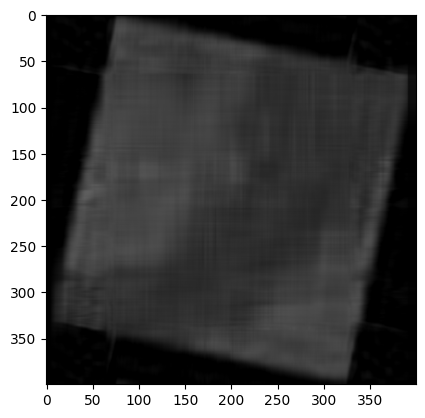

In [22]:
plt.imshow(img_reconstructed)

In [30]:
reconstructed_gray = color.rgb2gray(img_reconstructed)

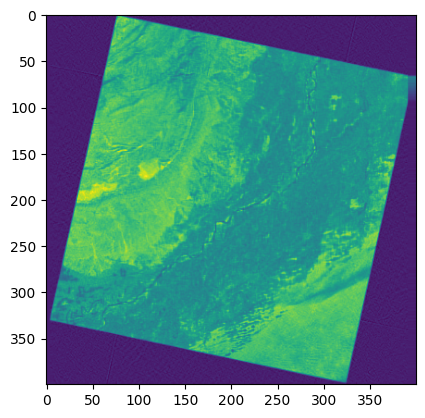

In [31]:
plt.imshow(reconstructed_gray)

In [32]:

def mse(actual, predicted):
    return np.square(np.subtract(np.array(actual), np.array(predicted))).mean() 

def rmse(predicted, actual):
    return np.sqrt(mse(predicted,actual))

print('Mean Sqaure Error = '+ str(mse(lina_gray,reconstructed_gray)))
print('Root MSE = '+ str(rmse(lina_gray,reconstructed_gray)))


Mean Sqaure Error = 7.830003965600615e-05
Root MSE = 0.008848730963025497
